### دریافت همه داده های راه رفتن 5 نفر


In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


# لیست فایل‌ها
file_list = ['LOG2.TXT', 'LOG7.TXT', 'LOG8.TXT', 'LOG10.TXT', 'LOG13.TXT']

# ستون‌های خروجی
columns = [
    'Time', 'angle',
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z'
]

# ستون‌های ویژگی برای LSTM
feature_columns = [
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z'
]

all_dfs = []  # لیست برای نگهداری تمام دیتافریم‌ها

# تابع پردازش یک فایل
def parse_file(filename):
    data = []
    with open(filename, 'r') as file:
        lines = file.readlines()

    for line_num, line in enumerate(lines):
        line = line.strip()
        if not line:
            continue

        # استخراج زمان
        time_match = re.search(r'Time:\s*(\d+)\s*ms', line)
        time = int(time_match.group(1)) if time_match else None

        # استخراج زاویه
        angle_match = re.search(r'Angle: ([\-\d.]+)Â°', line)
        if angle_match:
            angle=float(angle_match.group(1))
        else:
            angle=np.nan

        # استخراج MPU1 Acc — انواع فرمت
        mpu1_acc_match = re.search(r'MPU1(?: Acc| A cc)?\s*:\s*([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)', line)
        
        # استخراج MPU1 Gyro — با یا بدون "MPU1" قبل از Gyro
        mpu1_gyro_match = re.search(r'MPU1.*?Gyro\s*:\s*([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)', line)
        if not mpu1_gyro_match:
            mpu1_gyro_match = re.search(r'Gyro\s*:\s*([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)', line.split('||')[1] if '||' in line else line)

        # استخراج MPU2 Acc
        mpu2_acc_match = re.search(r'MPU2 Acc\s*:\s*([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)', line)
        
        # استخراج MPU2 Gyro
        mpu2_gyro_match = re.search(r'MPU2.*?Gyro\s*:\s*([-\d.]+),\s*([-\d.]+),\s*([-\d.]+)', line)

        def extract_values(match):
            if match:
                try:
                    return [float(match.group(i)) for i in range(1, 4)]
                except (IndexError, ValueError):
                    return [np.nan] * 3
            return [np.nan] * 3

        mpu1_acc = extract_values(mpu1_acc_match)
        mpu1_gyro = extract_values(mpu1_gyro_match)
        mpu2_acc = extract_values(mpu2_acc_match)
        mpu2_gyro = extract_values(mpu2_gyro_match)

        data.append([
            time, angle,
            mpu1_acc[0], mpu1_acc[1], mpu1_acc[2],
            mpu1_gyro[0], mpu1_gyro[1], mpu1_gyro[2],
            mpu2_acc[0], mpu2_acc[1], mpu2_acc[2],
            mpu2_gyro[0], mpu2_gyro[1], mpu2_gyro[2]
        ])
    
    df = pd.DataFrame(data, columns=columns)
    return df




# خواندن و پردازش تمام فایل‌ها
for filename in file_list:
    print(f"در حال پردازش {filename}...")
    df = parse_file(filename)
    df['source'] = filename  # برای تشخیص منبع (اختیاری)
    all_dfs.append(df)

# ترکیب تمام دیتافریم‌ها
df_combined = pd.concat(all_dfs, ignore_index=True)
print("\ndf_combined shape : ", df_combined.shape)

# حذف NaN و آماده‌سازی داده‌ها
df_clean = df_combined.dropna().reset_index(drop=True)
print("df_clean shape :  ", df_clean.shape)



در حال پردازش LOG2.TXT...
در حال پردازش LOG7.TXT...
در حال پردازش LOG8.TXT...
در حال پردازش LOG10.TXT...
در حال پردازش LOG13.TXT...

df_combined shape :  (87404, 15)
df_clean shape :   (87394, 15)


### فیلتر کردن و کلیپ کردن 

In [2]:
def low_pass_butter(signal, cutoff=10, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)


# After creating df_clean
print("Applying low-pass filter to sensor signals...")

# Define cutoff frequency and sampling rate
fs = 100      # Hz
cutoff = 12   # Hz


df_filtered = pd.DataFrame()

for col in feature_columns:
    df_filtered[col] = low_pass_butter(df_clean[col].values, cutoff=cutoff, fs=fs, order=2)

print("Filtering completed.")




# اعمال حد مجاز [-200, 200] روی تمام ژیروسکوپ‌ها
for col in ['MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z','MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z']:
    df_filtered[col] = np.clip(df_filtered[col], -200, 200)

# اعمال حد مجاز [-10, 10] روی تمام ژیروسکوپ‌ها
for col in ['MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z', 'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z']:
    df_filtered[col] = np.clip(df_filtered[col], -10, 10)

print("clipping completed.")

print("\ndf_filtered shape:",df_filtered.shape)

Applying low-pass filter to sensor signals...
Filtering completed.
clipping completed.

df_filtered shape: (87394, 12)


### پنجره بندی و استاندارد سازی 

In [15]:
# استانداردسازی ویژگی‌ها

# df_filtered shape: (87394, 12)
scaler = StandardScaler()
X_data = scaler.fit_transform(df_filtered[feature_columns].values)  # (T, 12)


y_scaler = StandardScaler()
y_data = y_scaler.fit_transform(df_clean['angle'].values.reshape(-1, 1)).flatten()
# تنظیمات پنجره
window_size = 150   # ~1 ثانیه با 100Hz
step_size = 75      # 50% هم‌پوشانی

# تابع پنجره‌بندی
def create_windows_with_labels(X, y, window_size, step_size):
    X_windows = []
    y_windows = []
    for i in range(0, len(X) - window_size + 1, step_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size - 1])  # برچسب آخرین نمونه در پنجره
    return np.array(X_windows), np.array(y_windows)

# ایجاد پنجره‌ها
X_windows, y_windows = create_windows_with_labels(X_data, y_data, window_size, step_size)

print(f"\n Total number of windows: {X_windows.shape[0]}")
print(f" Input data shape (X_windows):(samples, time steps, features) → {X_windows.shape}")
print(f" Label shape (y_windows): {y_windows.shape}")




 Total number of windows: 1164
 Input data shape (X_windows):(samples, time steps, features) → (1164, 150, 12)
 Label shape (y_windows): (1164,)


### ساخت شبکه LSTM

Model: "LSTM_reg_final"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 150, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150, 64)        │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

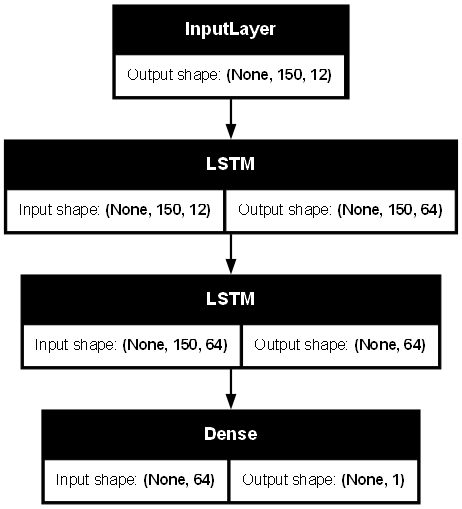

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, ReLU
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model



LEARNING_RATE = 0.0001
lambda_loss_amount = 0.0005


def build_lstm_model2(input_shape, n_hidden):
    inputs = Input(shape=input_shape, name="input")

    # یک لایه LSTM که فقط آخرین خروجی را برگرداند

    # Stacked LSTM layers
    x = LSTM(n_hidden, return_sequences=True)(inputs)   # 1st LSTM layer
    x = LSTM(n_hidden, return_sequences=False)(x)

    # x = LSTM(n_hidden, return_sequences=False)(inputs)

    # خروجی نهایی فقط یک عدد است (مثلاً y_t)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs, name="LSTM_reg_final")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    return model



final_model = build_lstm_model2(input_shape=(X_windows.shape[1],X_windows.shape[2]), n_hidden=64)

final_model.summary()


plot_model(final_model, show_shapes=True , dpi=80)



### آموزش شبکه

In [17]:
# X_windows.shape = (1343, 130, 12)
# y_windows.shape = (1343,)

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

X_train = X_windows[:1000,:,:]
X_test  = X_windows[1000:,:,:]
y_train = y_windows[:1000]
y_test  = y_windows[1000:]

# Define the callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath='best_lstm_model_reg.keras',  # Filepath to save the best model
    monitor='loss',                        # Metric to monitor
    save_best_only=True,                   # Save only the best model
    verbose=1                              # Print messages when saving
)




# Fit the model with the callback
history = final_model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9867 - mae: 0.7996
Epoch 1: loss improved from inf to 0.99227, saving model to best_lstm_model_reg.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.9871 - mae: 0.7994
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.8569 - mae: 0.7401
Epoch 2: loss improved from 0.99227 to 0.85879, saving model to best_lstm_model_reg.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.8570 - mae: 0.7396
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.7588 - mae: 0.6833
Epoch 3: loss improved from 0.85879 to 0.74344, saving model to best_lstm_model_reg.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.7579 - mae: 0.6830
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.6310 - mae: 0.6298
Epoch 4: loss improved from 0.74344 to 0.63273, saving model to best_lstm_model_reg.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.6311 - mae: 0.6294
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 65

In [34]:
y_pred = y_scaler.inverse_transform(final_model.predict(X_test))
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mae    = mean_absolute_error(y_test, y_pred)
mae

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


3386447381153.95